Importar Librerias

In [2]:
import pandas as pd
import numpy as np
import datetime
from itertools import compress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Leer Datos

In [3]:
DATOS_TRANSACCIONALES = pd.read_parquet('sample_data_0006_part_00.parquet', engine='pyarrow')

Reto 

Fraccionamiento Transaccional: esta mala práctica consiste en fraccionar una transacción en
un número mayor de transacciones con menor monto que agrupadas suman el valor de la
transacción original. Estas transacciones se caracterizan por estar en una misma ventana de
tiempo que suele ser 24 horas y tienen como origen o destino la misma cuenta o cliente.

Para llevar a cabo el desarrollo del reto se va a emplear la metodología CRISP-DM

1) Entendimiento del reto: 
Contamos con una base transaccional que tiene en cuenta transacciones tanto crédito como debito, es decir salidas y entradas respectivamente, y así mismo para cada una de ellas, el monto de la transacción, la fecha de la transacción y la cuenta a la que se envía o desde la que se recibe la transacción. 

Como estamos interesados en el fraccionamiento transaccional, se entiende que, se recibe una transacción de tipo crédito y luego esta se envía a otra cuenta en un lapso de tiempo de 24 horas, por tanto si la transacción de crédito fue a las 12:15 del 18/08/2023 se analizarán las transacciones débito entre las 12:15 del 18/08/2023 y las 12:15 del 19/08/2023, si el valor de la transacción de crédito es igual al valor de las transacciones débito en esta ventana de tiempo y además tienen un mismo destino se marcará como "fraccionamiento transaccional".

2) Entendimiento de los datos: para llevar a cabo este punto se realizarán algunos análisis de los datos transaccionales que se tienen, mediante diferente estadisticos.

Tenemos una base con 10.758.418 transacciones

In [6]:
DATOS_TRANSACCIONALES.shape

(10758418, 8)

Observamos que nuestra base de datos, no tiene valores nulos que puedan afectar nuestro análisis posterior, o a los que debamos hacerle algún tratamiento adicional

In [7]:
DATOS_TRANSACCIONALES.isnull().values.any()

False

En cuanto a los tipos de variables que tenemos, identificamos que 7 variables son string y 1 es tipo date.

In [8]:
DATOS_TRANSACCIONALES.dtypes

merchant_id                   object
_id                           object
subsidiary                    object
transaction_date      datetime64[ns]
account_number                object
user_id                       object
transaction_amount            object
transaction_type              object
dtype: object

A continuación, se hacen algunos gráficos para identificar comportamientos en algunas variables

In [68]:
B1 = DATOS_TRANSACCIONALES.groupby([pd.Grouper(key='transaction_date', freq='D')])['_id'].count().reset_index()

En la siguiente gráfica se observa que tenemos transacciones desde enero a diciembre del 2021, donde la tendencia en cantidad de transacciones realizadas es en el mes de febrero, luego disminuyen significativamente en marzo y nuevamente mes a mes empiezan a crecer. 

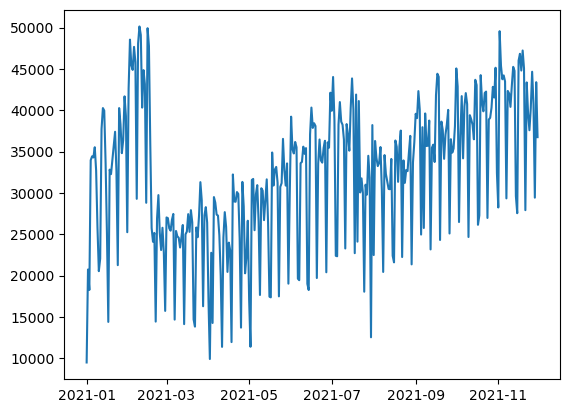

In [69]:
plt.plot(B1.transaction_date,B1._id)

(array([9.346585e+06, 1.236497e+06, 1.533730e+05, 9.842000e+03,
        3.526000e+03, 4.600000e+03, 3.994000e+03, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([   5.94445501,  467.82860947,  929.71276393, 1391.59691839,
        1853.48107285, 2315.36522731, 2777.24938177, 3239.13353623,
        3701.01769069, 4162.90184515, 4624.78599961]),
 <BarContainer object of 10 artists>)

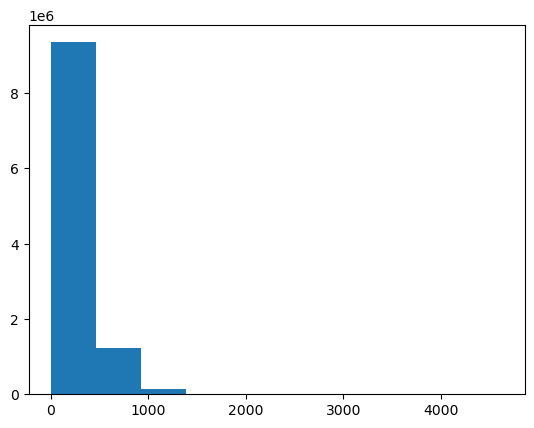

In [60]:
plt.hist(DATOS_TRANSACCIONALES['transaction_amount'])

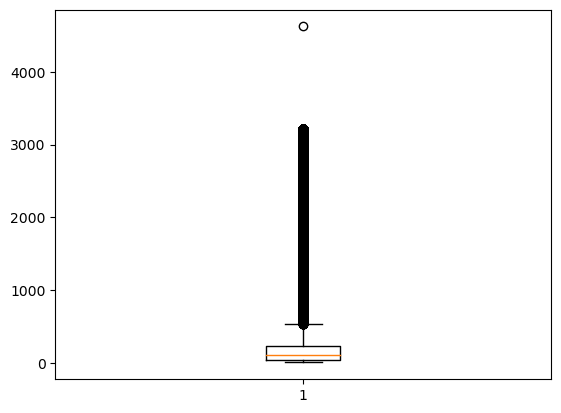

In [64]:
plt.figure()
_ = plt.boxplot(DATOS_TRANSACCIONALES['transaction_amount'].astype('float'))

Inicialmente en nuestros datos, no tenemos una variable respuesta, por tanto nuestro primer paso es construirla, a partir de las definiciones que nos da el problema de cuando es o no un fraccionamiento transaccional.

In [9]:
## Para las transacciones crédito, creamos el intervalo de 24 horas donde se revisarán las transacciones débito
DATOS_TRX_CREDITO=DATOS_TRANSACCIONALES[DATOS_TRANSACCIONALES['transaction_type'] == 'CREDITO']
DATOS_TRX_CREDITO["MAX_TIME"]=DATOS_TRX_CREDITO.transaction_date+datetime.timedelta(days=1)
DATOS_TRX_CREDITO=DATOS_TRX_CREDITO[['_id','user_id','account_number','transaction_date','MAX_TIME']]

C:\Users\ytati\AppData\Local\Temp\ipykernel_7380\510783684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATOS_TRX_CREDITO["MAX_TIME"]=DATOS_TRX_CREDITO.transaction_date+datetime.timedelta(days=1)


In [10]:
## Agregar el intervalo de consulta 24 horas a la base transaccional original
FULL_DATA=DATOS_TRANSACCIONALES.merge(DATOS_TRX_CREDITO,on=('user_id','account_number'),suffixes=("","_CREDIT"),how='left')

In [11]:
## Dejamos sólo las transacciones que se encuentran entre la fecha de la transacción crédito y la fecha de la transacción crédito +24 horas
FULL_DATA=FULL_DATA[(FULL_DATA['transaction_date']<=FULL_DATA['MAX_TIME']) & (FULL_DATA['transaction_date']>=FULL_DATA['transaction_date_CREDIT'])]

In [12]:
## Conteo de transacciones por user_id, account_number y fecha de la transacción de crédito
DATOS_TRANSACCIONALES_GROUPED=FULL_DATA.groupby(['user_id','account_number','transaction_date_CREDIT'])
DATOS_TRANSACCIONALES_GROUPED_END=pd.DataFrame(DATOS_TRANSACCIONALES_GROUPED['_id'].count()).reset_index()
#DATOS_TRANSACCIONALES_GROUPED_END=pd.DataFrame(DATOS_TRANSACCIONALES_GROUPED_END).reset_index()

In [13]:
## crear funciones de conteo
def count_credit(x):return list(x).count("CREDITO")
def count_debit(x):return list(x).count("DEBITO")

In [14]:
## Suma y conteo por transacciones debito y crédito con respecto a la fecha de la transacción crédito y la fecha de la transaccion crédito +24horas
DATOS_TRANSACCIONALES_GROUPED_END['CANTIDAD_CREDITO']=DATOS_TRANSACCIONALES_GROUPED['transaction_type'].agg([("temp_fun",count_credit)]).reset_index().temp_fun
DATOS_TRANSACCIONALES_GROUPED_END['CANTIDAD_DEBITO']=DATOS_TRANSACCIONALES_GROUPED['transaction_type'].agg([("temp_fun",count_debit)]).reset_index().temp_fun
DATOS_TRANSACCIONALES_GROUPED_END['MONTO_CREDITO']=DATOS_TRANSACCIONALES_GROUPED.apply(lambda x:np.sum(list(compress(x['transaction_amount'],[(lambda y: True if y=="CREDITO" else False)(X) for X in x['transaction_type']])))).reset_index().iloc[:,3]
DATOS_TRANSACCIONALES_GROUPED_END['MONTO_DEBITO']=DATOS_TRANSACCIONALES_GROUPED.apply(lambda x:np.sum(list(compress(x['transaction_amount'],[(lambda y: True if y=="DEBITO" else False)(X) for X in x['transaction_type']])))).reset_index().iloc[:,3]

Definición de casos con fraccionamiento transaccional

Regla: El monto debito == monto crédito en el intervalo transaccion crédito y transaccion crédito +24horas

Cantidad de transacciones crédito = 1

Cantidad de débito >= 2 (indica fraccionamiento de la transacción)

Como ya anteriormente agrupamos por account_number, ya tenemos las trx que sólo envían o reciben de la misma cuenta. 

In [15]:
CASOS_END=DATOS_TRANSACCIONALES_GROUPED_END[(DATOS_TRANSACCIONALES_GROUPED_END['MONTO_CREDITO']==DATOS_TRANSACCIONALES_GROUPED_END['MONTO_DEBITO']) & (DATOS_TRANSACCIONALES_GROUPED_END['CANTIDAD_CREDITO']<2) & (DATOS_TRANSACCIONALES_GROUPED_END['CANTIDAD_DEBITO']>1) ].sort_values(by='CANTIDAD_DEBITO',ascending=False)
FULL_CASOS_END=CASOS_END.loc[:,['user_id','account_number','transaction_date_CREDIT','CANTIDAD_CREDITO','CANTIDAD_DEBITO','MONTO_CREDITO','MONTO_DEBITO']].merge(FULL_DATA,on=('user_id','account_number','transaction_date_CREDIT'),how='inner')

Se identificaron 1216 casos de fraccionamiento transaccional. Es importante notar que se identificaron otros tipos de comportamientos transaccionales como por ejemplo, primero salen las transacciones de debito y luego entra la transacción de crédito, o por ejemplo, que para muchos casos no fraccionan la transacción sino la reenvian segundos después a otra cuenta por el mismo valor. 

In [16]:
FULL_CASOS_END.shape

(1216, 15)

Agregar Flag a la base transaccional original

In [17]:
DATOS_TRANSACCIONALES = DATOS_TRANSACCIONALES.merge(FULL_CASOS_END[['_id','_id_CREDIT']], on = '_id', how = 'left')

In [18]:
DATOS_TRANSACCIONALES['_id_CREDIT'] = np.where(pd.isna(DATOS_TRANSACCIONALES['_id_CREDIT']),'0','1')

In [22]:
DATOS_TRANSACCIONALES.rename(columns={'_id_CREDIT':'Flag'},
               inplace=True)

3) Modelaje y Evaluación

Para la parte de modelaje, como ya se tiene identificada la variable objetivo que es "Flag", ahora de nuestro set de variables, queremos ver cuales nos pueden funcionar para predecir si es una transacción o no fraccionada. Para ello, de las 8 iniciales sabemos que todas las que representan un "identificador" tales como account_number, _id, merchant_id, subsidiary y user_id no pueden ser usadas en el modelo, de tal manera que nos queden dos variables para usar, las cuales son, transaction_amount y transaction_type.

Se prueban dos modelos, 1) una regresión logistica y 2) un random forest

In [43]:
BASE_MODELO = DATOS_TRANSACCIONALES[['_id','transaction_amount','transaction_type']].set_index('_id')

In [45]:
BASE_MODELO['DEBITO'] = np.where(BASE_MODELO['transaction_type'] == "DEBITO","1","0")
BASE_MODELO['CREDITO'] = np.where(BASE_MODELO['transaction_type'] == "CREDITO","1","0")
BASE_MODELO = BASE_MODELO.drop('transaction_type', axis = 1)

In [46]:
train_X, test_X, train_Y, test_Y = train_test_split(BASE_MODELO, DATOS_TRANSACCIONALES['Flag'], test_size = 0.25, random_state = 42,  stratify=  DATOS_TRANSACCIONALES['Flag'])

Regresión Logistica

In [47]:
modelo = LogisticRegression(penalty='none')
modelo.fit(X = train_X, y = train_Y)

C:\Users\ytati\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(penalty='none')

In [48]:
predicciones = modelo.predict(X = test_X)

In [49]:
accuracy = accuracy_score(
            y_true    = test_Y,
            y_pred    = predicciones,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 99.98869722505721%


Random Forest

In [50]:
rf = RandomForestClassifier()
rf.fit(train_X, train_Y)

RandomForestClassifier()

In [51]:
predictions = rf.predict(test_X)

In [52]:
mat_confusion = confusion_matrix(
                    y_true    = test_Y,
                    y_pred    = predictions
                )

accuracy = accuracy_score(
            y_true    = test_Y,
            y_pred    = predictions,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

Matriz de confusión
-------------------
[[2689301       0]
 [    304       0]]

El accuracy de test es: 99.98869722505721 %


El accuracy para los dos modelos es del 99%, sin embargo, al ver los casos que identifico correctamente en la matriz de confusión nos damos cuenta que son cero, por tanto no es correcto. Al incorporar otras variables como la cantidad de debitos, cantidad de creditos,etc, que se usaron para determinar la transacción fraccionada es aplicar de nuevo la parte 1, y pues en ese sentido, sólo habría que definir las reglas y tendriamos la certeza del 100% de los casos. Ahora si se pensará en un modelo predictivo, tendríamos que tal vez incorporar otro tipo de información demográfica que nos permitan predecir estas situaciones.Por tanto, se propone un modelo de reglas que corresponde con la primera parte del ejercicio y es encontrar las transacciones fraccionadas.

4) Despliegue

Arquitectura ideal: Este modelo de reglas se puede implementar en batch o en linea, todo dependerá de los recursos de infraestructura y técnologicos que se tengan. 

Primero, Se debe garantizar la misma estructura de los datos analizados.  
Segundo, la preparación de los datos, debido a que sólo se toman las variables transaccionales sin ningún preprocesamiento para el modelo, no es necesario realizar ninguna transformación o preparación en los datos que se requieren en el modelo, sólo dejar las transacciones del periodo que se quieren evaluar.
Tercero, la ejecución del modelo, puede realizarse en cualquier software o ambiente donde se pueda desplegar un modelo de reglas, por ejemplo, python, GCP, AWS, Dataiku, etc...
Cuarto, la traza del modelo debe guardarse, por ello es necesario que si se ejecuta cada 24 horas o con la periodicidad que se requiera, se deje como salida un archivo plano que en lo posible se almacene en un datalake, esto para consulta, monitoreo y entrenamiento posterior.

5) Monitoreo 

A pesar de que el modelo sea de reglas, se deben monitorear los resultados, tomando un muestreo aleatorio de tal manera que permita identificar que esta clasificando correctamente o incorrectamente. Esto se debería realizar al menos de manera mensual. Así mismo, es interesante agregar sensores que permitan identificar comportamientos en las transacciones fraccionadas tales como su crecimiento, etc.